# Dog Heart Vertebral Heart Size Point Detection 
# 1. Build an object detection model using pytorch

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
import torch
from scipy.io import loadmat
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from torchmetrics.classification import MulticlassAccuracy
from torchvision.models import resnet50
from efficientnet_pytorch import EfficientNet
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error, mean_absolute_error
import gc
filterwarnings('ignore')

In [2]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True
torch.cuda.empty_cache()

In [3]:
# Check the code carefully!
class DogHeartDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "Images"))))
        self.points = list(sorted(os.listdir(os.path.join(root, "Labels"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "Images", self.imgs[idx])
        points_path = os.path.join(self.root, "Labels", self.points[idx])
        img = Image.open(img_path).convert("RGB")
        w, h = img.size
        if self.transforms is not None:
            img = self.transforms(img)
        h_new, w_new = img.shape[1], img.shape[2]
        mat = loadmat(points_path)
        six_points = mat['six_points'].astype(float)
        six_points = torch.as_tensor(six_points, dtype=torch.float32)
        six_points[:,0] = w_new/w*six_points[:,0] # Resize image to any size and maintain original points
        six_points[:,1] = h_new/h*six_points[:,1]
        six_points = torch.reshape(six_points, (-1,))/h_new # Normlize the points
        VHS = mat['VHS'].astype(float)
        VHS  = torch.as_tensor(VHS, dtype=torch.float32)
        return img, six_points, VHS

    def __len__(self):
        return len(self.imgs)
    

def get_transform(resized_image_size):
    transforms = []
    transforms.append(T.ToTensor())
    transforms.append(T.Resize(size = (resized_image_size,resized_image_size)))
    transforms.append(T.Normalize(mean = [0.485,0.456,0.406], std = [0.229, 0.224, 0.225]))
    return T.Compose(transforms)


## Read Train dataset using the dataloader
#For Resnet50
# batch_size = 16
# resized_image_size = 512
# learning_rate = 1e-4
# num_epochs = 200
# dataset_train = DogHeartDataset('Train', get_transform(resized_image_size))
# data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
# dataset_val = DogHeartDataset('Valid', get_transform(resized_image_size))
# data_loader_val = DataLoader(dataset_val, batch_size=1, shuffle=False)

#For EfficientNetB7
batch_size = 4
resized_image_size = 512
learning_rate = 1e-4
num_epochs = 200
dataset_train = DogHeartDataset('Train', get_transform(resized_image_size))
data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataset_val = DogHeartDataset('Valid', get_transform(resized_image_size))
data_loader_val = DataLoader(dataset_val, batch_size=1, shuffle=False)
    
    

# ## Get origial image size and return predicted points back to original points size
# w, h = img.size
# # Make predictions using trained model
# points = model(img)*resized_image_size
# points = torch.reshape(points, (-1, 2))
# points[:,0] = w/resized_image_size*points[:,0]
# points[:,1] = h/resized_image_size*points[:,1]



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


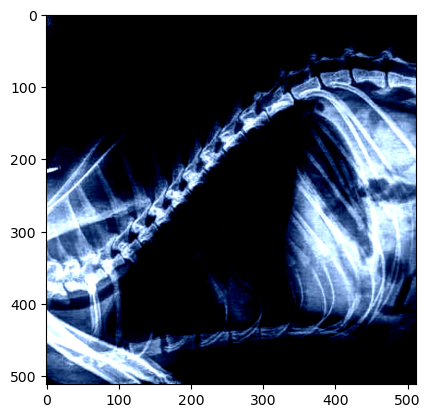

In [13]:
dataiter = iter(data_loader_train)
images, labels,_ = next(dataiter)
# Convert to (height, width, channels) for RGB images
plt.imshow(images[0].permute(1, 2, 0), cmap='gray')

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
    
class PointDetectionModel(nn.Module):
    def __init__(self, pretrained=True):
        super(PointDetectionModel, self).__init__()
        self.backbone = resnet50(pretrained=True)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 12)  # 6 points (x, y)

    def forward(self, x):
        return self.backbone(x)
    
class EfficientNetV2XLPointDetectionModel(nn.Module):
    def __init__(self, pretrained=True):
        super(EfficientNetV2XLPointDetectionModel, self).__init__()
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b7') if pretrained else EfficientNet.from_name('efficientnet-b7')
        self.fc = nn.Linear(self.efficientnet._fc.in_features, 12)  # 6 points with (x, y) coordinates
        self.efficientnet._fc = nn.Identity() 

    def forward(self, x):
        features = self.efficientnet(x)
        outputs = self.fc(features)
        return outputs



In [7]:
def classify_vhs(vhs):
    if vhs < 8.2:
        return 0  # Small
    elif 8.2 <= vhs <= 10:
        return 1  # Normal
    else:
        return 2  # Large
    


def calculate_vhs(points):
    if points.shape[0] != 12:
        print("Error: Incorrect number of points, expected 12 but got", points.shape[0])
    AB = torch.dist(points[0:2], points[2:4])
    CD = torch.dist(points[4:6], points[6:8])
    EF = torch.dist(points[8:10], points[10:12])
    VHS = 6 * (AB + CD) / EF
    return round(VHS.item(), 6) 



def calculate_metrics(vhs_true, vhs_pred):
    mse = mean_squared_error(vhs_true, vhs_pred)
    mae = mean_absolute_error(vhs_true, vhs_pred)
    true,pred = torch.tensor(vhs_true), torch.tensor(vhs_pred)
    mape = torch.mean(torch.abs((true - pred) / true)) * 100
    return mse, mae, mape


class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pth'):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


# 2. Train your model using [Dog VHS Dataset](https://yuad-my.sharepoint.com/:f:/g/personal/youshan_zhang_yu_edu/ErguFJBE4y9KqzEdWWNlXzMBkTbsBaNX9l856SyvQauwJg?e=L3JOuN)

In [ ]:
# model = PointDetectionModel(pretrained=True).to(device)
model = EfficientNetV2XLPointDetectionModel(pretrained=True).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)  
early_stopping = EarlyStopping(patience=5, verbose=True)
accuracy_metric = MulticlassAccuracy(num_classes=3)

In [ ]:
train_losses = []
val_losses = []
train_vhs_true, train_vhs_pred = [], []
val_vhs_true, val_vhs_pred = [],[]
train_vhs_true_class, train_vhs_pred_class = [], []
val_vhs_true_class, val_vhs_pred_class = [],[]

torch.cuda.manual_seed(8)

for epoch in range(num_epochs):
    model.train()
    train_vhs_pred, train_vhs_true = [], []  # Reset for each epoch
    train_vhs_true_class, train_vhs_pred_class = [], []
    running_train_loss = 0.0
    for imgs, six_points, vhs in tqdm(data_loader_train, unit="batch"):
        imgs, six_points = imgs.to(device), six_points.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, six_points)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        imgs,six_points = imgs.cpu(),six_points.cpu()
        
        for i in range(len(vhs)):
            vhs_pred = calculate_vhs(outputs[i].view(-1).cpu())
            train_vhs_true.append(vhs[i].cpu().item()) 
            train_vhs_pred.append(vhs_pred)
            train_vhs_true_class.append(classify_vhs(vhs[i].cpu().item()))  # Classify VHS
            train_vhs_pred_class.append(classify_vhs(vhs_pred))
    
    avg_train_loss = running_train_loss / len(data_loader_train) *100
    train_losses.append(avg_train_loss)
    
    train_accuracy = accuracy_metric(torch.tensor(train_vhs_pred_class), torch.tensor(train_vhs_true_class))
    
    model.eval()
    running_val_loss = 0.0
    val_vhs_true, val_vhs_pred = [], []  # Reset for each epoch
    val_vhs_true_class, val_vhs_pred_class = [], []
    with torch.no_grad():
        for imgs, six_points, vhs in tqdm(data_loader_val, unit="batch"):
            imgs, six_points = imgs.to(device), six_points.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, six_points)
            running_val_loss += loss.item()
            imgs,six_points = imgs.cpu(),six_points.cpu()
            
            for i in range(len(vhs)):
                vhs_pred = calculate_vhs(outputs[i].view(-1).cpu())
                val_vhs_true.append(vhs[i].cpu().item()) 
                val_vhs_pred.append(vhs_pred)
                val_vhs_true_class.append(classify_vhs(vhs[i].cpu().item()))  # Classify VHS
                val_vhs_pred_class.append(classify_vhs(vhs_pred))
    
    avg_val_loss = running_val_loss / len(data_loader_val) *100
    val_losses.append(avg_val_loss)
    
    val_accuracy = accuracy_metric(torch.tensor(val_vhs_pred_class), torch.tensor(val_vhs_true_class))
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
    print(f"Training Accuracy: {train_accuracy.item():.2%}, Validation Accuracy: {val_accuracy.item():.2%}")
    
    scheduler.step(avg_val_loss)
    # early_stopping(avg_val_loss,val_accuracy , model)
    # early_stopping(avg_val_loss, model)
    
    # if early_stopping.early_stop:
    #     print("Early stopping")
    #     break

    # Clear GPU cache
    torch.cuda.empty_cache()
    gc.collect()



100%|██████████| 200/200 [00:16<00:00, 11.79batch/s]


Epoch [1/200], Training Loss: 2.3576, Validation Loss: 0.2071
Training Accuracy: 36.19%, Validation Accuracy: 60.23%


100%|██████████| 200/200 [00:16<00:00, 11.77batch/s]


Epoch [2/200], Training Loss: 0.1747, Validation Loss: 0.1427
Training Accuracy: 43.36%, Validation Accuracy: 59.09%


100%|██████████| 200/200 [00:17<00:00, 11.36batch/s]


Epoch [3/200], Training Loss: 0.1128, Validation Loss: 0.0772
Training Accuracy: 43.06%, Validation Accuracy: 48.88%


100%|██████████| 200/200 [00:17<00:00, 11.54batch/s]


Epoch [4/200], Training Loss: 0.0788, Validation Loss: 0.0783
Training Accuracy: 45.85%, Validation Accuracy: 60.12%


100%|██████████| 200/200 [00:17<00:00, 11.72batch/s]


Epoch [5/200], Training Loss: 0.0580, Validation Loss: 0.0699
Training Accuracy: 46.35%, Validation Accuracy: 49.06%


100%|██████████| 200/200 [00:17<00:00, 11.76batch/s]


Epoch [6/200], Training Loss: 0.0557, Validation Loss: 0.0608
Training Accuracy: 48.15%, Validation Accuracy: 46.97%


100%|██████████| 200/200 [00:17<00:00, 11.45batch/s]


Epoch [7/200], Training Loss: 0.0474, Validation Loss: 0.0623
Training Accuracy: 47.41%, Validation Accuracy: 49.43%


100%|██████████| 200/200 [00:16<00:00, 11.99batch/s]


Epoch [8/200], Training Loss: 0.0440, Validation Loss: 0.0690
Training Accuracy: 48.96%, Validation Accuracy: 64.56%


100%|██████████| 200/200 [00:16<00:00, 11.99batch/s]


Epoch [9/200], Training Loss: 0.0505, Validation Loss: 0.0609
Training Accuracy: 50.72%, Validation Accuracy: 53.21%


100%|██████████| 200/200 [00:16<00:00, 12.00batch/s]


Epoch [10/200], Training Loss: 0.0543, Validation Loss: 0.0591
Training Accuracy: 53.08%, Validation Accuracy: 55.41%


100%|██████████| 200/200 [00:16<00:00, 11.90batch/s]


Epoch [11/200], Training Loss: 0.0445, Validation Loss: 0.0683
Training Accuracy: 49.67%, Validation Accuracy: 70.45%


100%|██████████| 200/200 [00:16<00:00, 11.80batch/s]


Epoch [12/200], Training Loss: 0.0353, Validation Loss: 0.0757
Training Accuracy: 50.62%, Validation Accuracy: 71.06%


100%|██████████| 200/200 [00:17<00:00, 11.59batch/s]


Epoch [13/200], Training Loss: 0.0317, Validation Loss: 0.0661
Training Accuracy: 53.34%, Validation Accuracy: 67.22%


100%|██████████| 200/200 [00:16<00:00, 11.92batch/s]


Epoch [14/200], Training Loss: 0.0330, Validation Loss: 0.0572
Training Accuracy: 51.48%, Validation Accuracy: 55.03%


100%|██████████| 200/200 [00:16<00:00, 11.92batch/s]


Epoch [15/200], Training Loss: 0.0297, Validation Loss: 0.0568
Training Accuracy: 53.21%, Validation Accuracy: 64.33%


100%|██████████| 200/200 [00:16<00:00, 12.03batch/s]


Epoch [16/200], Training Loss: 0.0280, Validation Loss: 0.0517
Training Accuracy: 51.15%, Validation Accuracy: 49.30%


100%|██████████| 200/200 [00:16<00:00, 12.03batch/s]


Epoch [17/200], Training Loss: 0.0310, Validation Loss: 0.0570
Training Accuracy: 54.65%, Validation Accuracy: 53.91%


100%|██████████| 200/200 [00:16<00:00, 12.01batch/s]


Epoch [18/200], Training Loss: 0.0289, Validation Loss: 0.0604
Training Accuracy: 50.31%, Validation Accuracy: 56.06%


100%|██████████| 200/200 [00:16<00:00, 11.94batch/s]


Epoch [19/200], Training Loss: 0.0297, Validation Loss: 0.0580
Training Accuracy: 51.29%, Validation Accuracy: 62.88%


100%|██████████| 200/200 [00:15<00:00, 12.70batch/s]


Epoch [20/200], Training Loss: 0.0234, Validation Loss: 0.0681
Training Accuracy: 50.18%, Validation Accuracy: 49.51%


100%|██████████| 200/200 [00:16<00:00, 12.45batch/s]


Epoch [21/200], Training Loss: 0.0272, Validation Loss: 0.0639
Training Accuracy: 51.98%, Validation Accuracy: 62.22%


100%|██████████| 200/200 [00:05<00:00, 37.50batch/s]


Epoch [22/200], Training Loss: 0.0234, Validation Loss: 0.0647
Training Accuracy: 51.18%, Validation Accuracy: 57.45%


100%|██████████| 200/200 [00:16<00:00, 12.20batch/s]


Epoch [23/200], Training Loss: 0.0237, Validation Loss: 0.0597
Training Accuracy: 51.48%, Validation Accuracy: 63.88%


100%|██████████| 200/200 [00:16<00:00, 12.47batch/s]


Epoch [24/200], Training Loss: 0.0195, Validation Loss: 0.0457
Training Accuracy: 51.20%, Validation Accuracy: 52.72%


100%|██████████| 200/200 [00:16<00:00, 12.12batch/s]


Epoch [25/200], Training Loss: 0.0195, Validation Loss: 0.0590
Training Accuracy: 52.17%, Validation Accuracy: 41.77%


100%|██████████| 200/200 [00:16<00:00, 11.96batch/s]


Epoch [26/200], Training Loss: 0.0173, Validation Loss: 0.0545
Training Accuracy: 52.36%, Validation Accuracy: 49.47%


100%|██████████| 200/200 [00:16<00:00, 11.98batch/s]


Epoch [27/200], Training Loss: 0.0205, Validation Loss: 0.0524
Training Accuracy: 51.54%, Validation Accuracy: 49.73%


100%|██████████| 200/200 [00:16<00:00, 12.00batch/s]


Epoch [28/200], Training Loss: 0.0212, Validation Loss: 0.0473
Training Accuracy: 53.06%, Validation Accuracy: 53.96%


100%|██████████| 200/200 [00:16<00:00, 12.02batch/s]


Epoch [29/200], Training Loss: 0.0185, Validation Loss: 0.0623
Training Accuracy: 52.04%, Validation Accuracy: 52.22%


100%|██████████| 200/200 [00:16<00:00, 12.00batch/s]


Epoch [30/200], Training Loss: 0.0192, Validation Loss: 0.0556
Training Accuracy: 51.89%, Validation Accuracy: 54.88%


100%|██████████| 200/200 [00:16<00:00, 12.00batch/s]


Epoch [31/200], Training Loss: 0.0186, Validation Loss: 0.0531
Training Accuracy: 52.59%, Validation Accuracy: 55.03%


100%|██████████| 200/200 [00:16<00:00, 12.04batch/s]


Epoch [32/200], Training Loss: 0.0217, Validation Loss: 0.0439
Training Accuracy: 52.63%, Validation Accuracy: 57.73%


100%|██████████| 200/200 [00:16<00:00, 12.00batch/s]


Epoch [33/200], Training Loss: 0.0189, Validation Loss: 0.0476
Training Accuracy: 52.03%, Validation Accuracy: 62.35%


100%|██████████| 200/200 [00:16<00:00, 12.00batch/s]


Epoch [34/200], Training Loss: 0.0152, Validation Loss: 0.0481
Training Accuracy: 52.85%, Validation Accuracy: 56.67%


100%|██████████| 200/200 [00:16<00:00, 11.93batch/s]


Epoch [35/200], Training Loss: 0.0160, Validation Loss: 0.0402
Training Accuracy: 52.28%, Validation Accuracy: 53.87%


100%|██████████| 200/200 [00:16<00:00, 12.06batch/s]


Epoch [36/200], Training Loss: 0.0168, Validation Loss: 0.0452
Training Accuracy: 52.33%, Validation Accuracy: 66.37%


100%|██████████| 200/200 [00:16<00:00, 12.05batch/s]


Epoch [37/200], Training Loss: 0.0143, Validation Loss: 0.0456
Training Accuracy: 51.80%, Validation Accuracy: 55.53%


100%|██████████| 200/200 [00:16<00:00, 12.00batch/s]


Epoch [38/200], Training Loss: 0.0177, Validation Loss: 0.0399
Training Accuracy: 52.71%, Validation Accuracy: 61.44%


100%|██████████| 200/200 [00:16<00:00, 11.97batch/s]


Epoch [39/200], Training Loss: 0.0150, Validation Loss: 0.0420
Training Accuracy: 54.22%, Validation Accuracy: 64.48%


100%|██████████| 200/200 [00:16<00:00, 12.02batch/s]


Epoch [40/200], Training Loss: 0.0151, Validation Loss: 0.0500
Training Accuracy: 52.18%, Validation Accuracy: 38.30%


100%|██████████| 200/200 [00:16<00:00, 11.98batch/s]


Epoch [41/200], Training Loss: 0.0175, Validation Loss: 0.0467
Training Accuracy: 53.63%, Validation Accuracy: 46.40%


100%|██████████| 200/200 [00:16<00:00, 11.98batch/s]


Epoch [42/200], Training Loss: 0.0252, Validation Loss: 0.0605
Training Accuracy: 52.89%, Validation Accuracy: 52.97%


100%|██████████| 200/200 [00:16<00:00, 11.96batch/s]


Epoch [43/200], Training Loss: 0.0147, Validation Loss: 0.0491
Training Accuracy: 51.88%, Validation Accuracy: 76.20%


100%|██████████| 200/200 [00:16<00:00, 11.90batch/s]


Epoch [44/200], Training Loss: 0.0146, Validation Loss: 0.0468
Training Accuracy: 54.12%, Validation Accuracy: 63.23%


100%|██████████| 200/200 [00:16<00:00, 11.98batch/s]


Epoch [45/200], Training Loss: 0.0138, Validation Loss: 0.0527
Training Accuracy: 52.60%, Validation Accuracy: 50.69%


100%|██████████| 200/200 [00:16<00:00, 11.97batch/s]


Epoch [46/200], Training Loss: 0.0136, Validation Loss: 0.0470
Training Accuracy: 53.54%, Validation Accuracy: 56.11%


100%|██████████| 200/200 [00:16<00:00, 11.94batch/s]


Epoch [47/200], Training Loss: 0.0129, Validation Loss: 0.0380
Training Accuracy: 53.05%, Validation Accuracy: 40.89%


100%|██████████| 200/200 [00:16<00:00, 11.92batch/s]


Epoch [48/200], Training Loss: 0.0112, Validation Loss: 0.0390
Training Accuracy: 52.50%, Validation Accuracy: 52.47%


100%|██████████| 200/200 [00:16<00:00, 11.99batch/s]


Epoch [49/200], Training Loss: 0.0128, Validation Loss: 0.0387
Training Accuracy: 53.69%, Validation Accuracy: 44.95%


100%|██████████| 200/200 [00:16<00:00, 12.03batch/s]


Epoch [50/200], Training Loss: 0.0131, Validation Loss: 0.0491
Training Accuracy: 53.67%, Validation Accuracy: 58.11%


100%|██████████| 200/200 [00:16<00:00, 12.02batch/s]


Epoch [51/200], Training Loss: 0.0124, Validation Loss: 0.0494
Training Accuracy: 51.76%, Validation Accuracy: 60.77%


100%|██████████| 200/200 [00:16<00:00, 12.07batch/s]


Epoch [52/200], Training Loss: 0.0130, Validation Loss: 0.0389
Training Accuracy: 51.37%, Validation Accuracy: 37.86%


100%|██████████| 200/200 [00:16<00:00, 11.90batch/s]


Epoch [53/200], Training Loss: 0.0135, Validation Loss: 0.0407
Training Accuracy: 52.09%, Validation Accuracy: 43.07%


100%|██████████| 200/200 [00:16<00:00, 11.93batch/s]


Epoch [54/200], Training Loss: 0.0115, Validation Loss: 0.0343
Training Accuracy: 52.58%, Validation Accuracy: 59.58%


100%|██████████| 200/200 [00:16<00:00, 12.02batch/s]


Epoch [55/200], Training Loss: 0.0108, Validation Loss: 0.0364
Training Accuracy: 51.51%, Validation Accuracy: 50.24%


100%|██████████| 200/200 [00:16<00:00, 11.92batch/s]


Epoch [56/200], Training Loss: 0.0119, Validation Loss: 0.0386
Training Accuracy: 52.33%, Validation Accuracy: 46.61%


100%|██████████| 200/200 [00:16<00:00, 12.05batch/s]


Epoch [57/200], Training Loss: 0.0119, Validation Loss: 0.0388
Training Accuracy: 54.14%, Validation Accuracy: 55.50%


100%|██████████| 200/200 [00:16<00:00, 11.89batch/s]


Epoch [58/200], Training Loss: 0.0114, Validation Loss: 0.0375
Training Accuracy: 53.07%, Validation Accuracy: 52.58%


100%|██████████| 200/200 [00:16<00:00, 11.94batch/s]


Epoch [59/200], Training Loss: 0.0120, Validation Loss: 0.0400
Training Accuracy: 53.08%, Validation Accuracy: 67.36%


100%|██████████| 200/200 [00:16<00:00, 12.00batch/s]


Epoch [60/200], Training Loss: 0.0113, Validation Loss: 0.0492
Training Accuracy: 51.38%, Validation Accuracy: 47.35%


100%|██████████| 200/200 [00:16<00:00, 12.03batch/s]


Epoch [61/200], Training Loss: 0.0121, Validation Loss: 0.0366
Training Accuracy: 51.31%, Validation Accuracy: 73.03%


100%|██████████| 200/200 [00:16<00:00, 11.99batch/s]


Epoch [62/200], Training Loss: 0.0104, Validation Loss: 0.0454
Training Accuracy: 53.94%, Validation Accuracy: 42.58%


100%|██████████| 200/200 [00:16<00:00, 11.92batch/s]


Epoch [63/200], Training Loss: 0.0117, Validation Loss: 0.0413
Training Accuracy: 52.27%, Validation Accuracy: 36.92%


100%|██████████| 200/200 [00:17<00:00, 11.58batch/s]


Epoch [64/200], Training Loss: 0.0118, Validation Loss: 0.0444
Training Accuracy: 52.59%, Validation Accuracy: 43.16%


100%|██████████| 200/200 [00:16<00:00, 12.05batch/s]


Epoch [65/200], Training Loss: 0.0146, Validation Loss: 0.0381
Training Accuracy: 53.88%, Validation Accuracy: 58.81%


100%|██████████| 200/200 [00:16<00:00, 11.94batch/s]


Epoch [66/200], Training Loss: 0.0106, Validation Loss: 0.0445
Training Accuracy: 52.35%, Validation Accuracy: 57.91%


100%|██████████| 200/200 [00:16<00:00, 12.09batch/s]


Epoch [67/200], Training Loss: 0.0107, Validation Loss: 0.0398
Training Accuracy: 52.55%, Validation Accuracy: 41.70%


100%|██████████| 200/200 [00:16<00:00, 12.01batch/s]


Epoch [68/200], Training Loss: 0.0102, Validation Loss: 0.0358
Training Accuracy: 54.16%, Validation Accuracy: 55.47%


100%|██████████| 200/200 [00:16<00:00, 12.05batch/s]


Epoch [69/200], Training Loss: 0.0111, Validation Loss: 0.0419
Training Accuracy: 53.19%, Validation Accuracy: 44.74%


100%|██████████| 200/200 [00:16<00:00, 12.00batch/s]


Epoch [70/200], Training Loss: 0.0132, Validation Loss: 0.0382
Training Accuracy: 52.48%, Validation Accuracy: 69.25%


100%|██████████| 200/200 [00:16<00:00, 12.01batch/s]


Epoch [71/200], Training Loss: 0.0123, Validation Loss: 0.0582
Training Accuracy: 53.50%, Validation Accuracy: 76.49%


100%|██████████| 200/200 [00:16<00:00, 12.01batch/s]


Epoch [72/200], Training Loss: 0.0104, Validation Loss: 0.0345
Training Accuracy: 56.09%, Validation Accuracy: 40.69%


100%|██████████| 200/200 [00:16<00:00, 12.08batch/s]


Epoch [73/200], Training Loss: 0.0101, Validation Loss: 0.0321
Training Accuracy: 52.69%, Validation Accuracy: 38.67%


100%|██████████| 200/200 [00:16<00:00, 12.08batch/s]


Epoch [74/200], Training Loss: 0.0096, Validation Loss: 0.0343
Training Accuracy: 52.28%, Validation Accuracy: 43.07%


100%|██████████| 200/200 [00:16<00:00, 12.13batch/s]


Epoch [75/200], Training Loss: 0.0095, Validation Loss: 0.0400
Training Accuracy: 52.22%, Validation Accuracy: 50.60%


100%|██████████| 200/200 [00:16<00:00, 12.00batch/s]


Epoch [76/200], Training Loss: 0.0101, Validation Loss: 0.0384
Training Accuracy: 51.62%, Validation Accuracy: 35.83%


100%|██████████| 200/200 [00:16<00:00, 11.99batch/s]


Epoch [77/200], Training Loss: 0.0091, Validation Loss: 0.0329
Training Accuracy: 51.75%, Validation Accuracy: 58.37%


100%|██████████| 200/200 [00:16<00:00, 11.99batch/s]


Epoch [78/200], Training Loss: 0.0105, Validation Loss: 0.0360
Training Accuracy: 54.02%, Validation Accuracy: 54.77%


100%|██████████| 200/200 [00:16<00:00, 12.16batch/s]


Epoch [79/200], Training Loss: 0.0113, Validation Loss: 0.0386
Training Accuracy: 52.49%, Validation Accuracy: 45.84%


100%|██████████| 200/200 [00:16<00:00, 11.90batch/s]


Epoch [80/200], Training Loss: 0.0093, Validation Loss: 0.0366
Training Accuracy: 52.77%, Validation Accuracy: 47.86%


100%|██████████| 200/200 [00:16<00:00, 11.96batch/s]


Epoch [81/200], Training Loss: 0.0090, Validation Loss: 0.0405
Training Accuracy: 52.47%, Validation Accuracy: 39.95%


100%|██████████| 200/200 [00:16<00:00, 11.98batch/s]


Epoch [82/200], Training Loss: 0.0122, Validation Loss: 0.0336
Training Accuracy: 53.54%, Validation Accuracy: 47.94%


100%|██████████| 200/200 [00:16<00:00, 12.10batch/s]


Epoch [83/200], Training Loss: 0.0113, Validation Loss: 0.0363
Training Accuracy: 54.33%, Validation Accuracy: 42.15%


100%|██████████| 200/200 [00:16<00:00, 11.99batch/s]


Epoch [84/200], Training Loss: 0.0106, Validation Loss: 0.0349
Training Accuracy: 52.70%, Validation Accuracy: 61.05%


100%|██████████| 200/200 [00:16<00:00, 12.09batch/s]


Epoch [85/200], Training Loss: 0.0107, Validation Loss: 0.0378
Training Accuracy: 52.27%, Validation Accuracy: 50.27%


100%|██████████| 200/200 [00:16<00:00, 12.01batch/s]


Epoch [86/200], Training Loss: 0.0097, Validation Loss: 0.0337
Training Accuracy: 52.38%, Validation Accuracy: 43.09%


100%|██████████| 200/200 [00:16<00:00, 12.00batch/s]


Epoch [87/200], Training Loss: 0.0097, Validation Loss: 0.0310
Training Accuracy: 52.19%, Validation Accuracy: 49.81%


100%|██████████| 200/200 [00:16<00:00, 11.90batch/s]


Epoch [88/200], Training Loss: 0.0096, Validation Loss: 0.0348
Training Accuracy: 52.46%, Validation Accuracy: 41.05%


100%|██████████| 200/200 [00:16<00:00, 12.02batch/s]


Epoch [89/200], Training Loss: 0.0097, Validation Loss: 0.0398
Training Accuracy: 52.43%, Validation Accuracy: 48.89%


100%|██████████| 200/200 [00:16<00:00, 11.87batch/s]


Epoch [90/200], Training Loss: 0.0088, Validation Loss: 0.0314
Training Accuracy: 52.50%, Validation Accuracy: 44.54%


100%|██████████| 200/200 [00:16<00:00, 12.05batch/s]


Epoch [91/200], Training Loss: 0.0080, Validation Loss: 0.0321
Training Accuracy: 52.40%, Validation Accuracy: 58.81%


100%|██████████| 200/200 [00:16<00:00, 11.99batch/s]


Epoch [92/200], Training Loss: 0.0081, Validation Loss: 0.0349
Training Accuracy: 52.66%, Validation Accuracy: 39.31%


100%|██████████| 200/200 [00:16<00:00, 12.01batch/s]


Epoch [93/200], Training Loss: 0.0089, Validation Loss: 0.0344
Training Accuracy: 52.39%, Validation Accuracy: 40.04%


100%|██████████| 200/200 [00:17<00:00, 11.69batch/s]


Epoch [94/200], Training Loss: 0.0085, Validation Loss: 0.0329
Training Accuracy: 53.36%, Validation Accuracy: 42.43%


100%|██████████| 200/200 [00:16<00:00, 12.06batch/s]


Epoch [95/200], Training Loss: 0.0075, Validation Loss: 0.0342
Training Accuracy: 52.48%, Validation Accuracy: 68.33%


100%|██████████| 200/200 [00:16<00:00, 11.97batch/s]


Epoch [96/200], Training Loss: 0.0072, Validation Loss: 0.0342
Training Accuracy: 52.38%, Validation Accuracy: 39.68%


100%|██████████| 200/200 [00:16<00:00, 12.01batch/s]


Epoch [97/200], Training Loss: 0.0083, Validation Loss: 0.0380
Training Accuracy: 51.89%, Validation Accuracy: 64.90%


100%|██████████| 200/200 [00:16<00:00, 12.08batch/s]


Epoch [98/200], Training Loss: 0.0085, Validation Loss: 0.0378
Training Accuracy: 52.54%, Validation Accuracy: 57.81%


100%|██████████| 200/200 [00:16<00:00, 12.00batch/s]


Epoch [99/200], Training Loss: 0.0083, Validation Loss: 0.0428
Training Accuracy: 52.27%, Validation Accuracy: 61.18%


100%|██████████| 200/200 [00:16<00:00, 12.04batch/s]


Epoch [100/200], Training Loss: 0.0072, Validation Loss: 0.0309
Training Accuracy: 51.78%, Validation Accuracy: 54.61%


100%|██████████| 200/200 [00:16<00:00, 12.01batch/s]


Epoch [101/200], Training Loss: 0.0074, Validation Loss: 0.0356
Training Accuracy: 52.43%, Validation Accuracy: 42.72%


100%|██████████| 200/200 [00:16<00:00, 12.02batch/s]


Epoch [102/200], Training Loss: 0.0076, Validation Loss: 0.0372
Training Accuracy: 51.97%, Validation Accuracy: 48.60%


100%|██████████| 200/200 [00:16<00:00, 11.99batch/s]


Epoch [103/200], Training Loss: 0.0083, Validation Loss: 0.0355
Training Accuracy: 51.90%, Validation Accuracy: 62.43%


100%|██████████| 200/200 [00:16<00:00, 12.04batch/s]


Epoch [104/200], Training Loss: 0.0112, Validation Loss: 0.0286
Training Accuracy: 53.97%, Validation Accuracy: 46.30%


100%|██████████| 200/200 [00:16<00:00, 12.02batch/s]


Epoch [105/200], Training Loss: 0.0093, Validation Loss: 0.0335
Training Accuracy: 52.96%, Validation Accuracy: 45.55%


100%|██████████| 200/200 [00:16<00:00, 12.05batch/s]


Epoch [106/200], Training Loss: 0.0076, Validation Loss: 0.0371
Training Accuracy: 53.33%, Validation Accuracy: 56.91%


100%|██████████| 200/200 [00:16<00:00, 12.01batch/s]


Epoch [107/200], Training Loss: 0.0086, Validation Loss: 0.0318
Training Accuracy: 52.14%, Validation Accuracy: 44.83%


100%|██████████| 200/200 [00:16<00:00, 12.02batch/s]


Epoch [108/200], Training Loss: 0.0061, Validation Loss: 0.0313
Training Accuracy: 52.05%, Validation Accuracy: 57.57%


100%|██████████| 200/200 [00:16<00:00, 12.06batch/s]


Epoch [109/200], Training Loss: 0.0070, Validation Loss: 0.0302
Training Accuracy: 52.41%, Validation Accuracy: 55.83%


100%|██████████| 200/200 [00:16<00:00, 12.05batch/s]


Epoch [110/200], Training Loss: 0.0056, Validation Loss: 0.0313
Training Accuracy: 52.87%, Validation Accuracy: 46.56%


100%|██████████| 200/200 [00:16<00:00, 12.00batch/s]


Epoch [111/200], Training Loss: 0.0067, Validation Loss: 0.0336
Training Accuracy: 52.39%, Validation Accuracy: 56.07%


100%|██████████| 200/200 [00:16<00:00, 11.94batch/s]


Epoch [112/200], Training Loss: 0.0065, Validation Loss: 0.0308
Training Accuracy: 51.60%, Validation Accuracy: 72.08%


100%|██████████| 200/200 [00:16<00:00, 11.96batch/s]


Epoch [113/200], Training Loss: 0.0052, Validation Loss: 0.0333
Training Accuracy: 54.01%, Validation Accuracy: 48.52%


100%|██████████| 200/200 [00:16<00:00, 12.07batch/s]


Epoch [114/200], Training Loss: 0.0059, Validation Loss: 0.0305
Training Accuracy: 52.17%, Validation Accuracy: 62.28%


100%|██████████| 200/200 [00:16<00:00, 12.01batch/s]


Epoch [115/200], Training Loss: 0.0065, Validation Loss: 0.0310
Training Accuracy: 53.68%, Validation Accuracy: 56.36%


100%|██████████| 200/200 [00:16<00:00, 11.97batch/s]


Epoch [116/200], Training Loss: 0.0065, Validation Loss: 0.0335
Training Accuracy: 51.78%, Validation Accuracy: 69.15%


100%|██████████| 200/200 [00:16<00:00, 12.10batch/s]


Epoch [117/200], Training Loss: 0.0081, Validation Loss: 0.0434
Training Accuracy: 53.50%, Validation Accuracy: 39.38%


100%|██████████| 200/200 [00:16<00:00, 12.00batch/s]


Epoch [118/200], Training Loss: 0.0058, Validation Loss: 0.0322
Training Accuracy: 53.42%, Validation Accuracy: 52.82%


100%|██████████| 200/200 [00:16<00:00, 11.98batch/s]


Epoch [119/200], Training Loss: 0.0071, Validation Loss: 0.0304
Training Accuracy: 52.41%, Validation Accuracy: 62.50%


100%|██████████| 200/200 [00:16<00:00, 11.94batch/s]


Epoch [120/200], Training Loss: 0.0063, Validation Loss: 0.0329
Training Accuracy: 52.75%, Validation Accuracy: 40.32%


100%|██████████| 200/200 [00:12<00:00, 15.46batch/s]


Epoch [121/200], Training Loss: 0.0060, Validation Loss: 0.0315
Training Accuracy: 52.01%, Validation Accuracy: 44.62%


100%|██████████| 200/200 [00:16<00:00, 12.08batch/s]


Epoch [122/200], Training Loss: 0.0077, Validation Loss: 0.0298
Training Accuracy: 53.17%, Validation Accuracy: 41.05%


100%|██████████| 200/200 [00:05<00:00, 37.17batch/s]


Epoch [123/200], Training Loss: 0.0064, Validation Loss: 0.0309
Training Accuracy: 52.60%, Validation Accuracy: 52.60%


100%|██████████| 200/200 [00:05<00:00, 37.87batch/s]


Epoch [124/200], Training Loss: 0.0072, Validation Loss: 0.0316
Training Accuracy: 53.69%, Validation Accuracy: 49.48%


100%|██████████| 200/200 [00:05<00:00, 36.87batch/s]


Epoch [125/200], Training Loss: 0.0082, Validation Loss: 0.0314
Training Accuracy: 52.48%, Validation Accuracy: 62.43%


100%|██████████| 200/200 [00:05<00:00, 37.89batch/s]


Epoch [126/200], Training Loss: 0.0066, Validation Loss: 0.0381
Training Accuracy: 53.17%, Validation Accuracy: 40.34%


100%|██████████| 200/200 [00:05<00:00, 37.65batch/s]


Epoch [127/200], Training Loss: 0.0070, Validation Loss: 0.0317
Training Accuracy: 52.77%, Validation Accuracy: 52.44%


100%|██████████| 200/200 [00:05<00:00, 37.29batch/s]


Epoch [128/200], Training Loss: 0.0059, Validation Loss: 0.0300
Training Accuracy: 52.43%, Validation Accuracy: 60.18%


100%|██████████| 200/200 [00:05<00:00, 37.96batch/s]


Epoch [129/200], Training Loss: 0.0059, Validation Loss: 0.0290
Training Accuracy: 52.39%, Validation Accuracy: 42.81%


100%|██████████| 200/200 [00:05<00:00, 37.27batch/s]


Epoch [130/200], Training Loss: 0.0048, Validation Loss: 0.0311
Training Accuracy: 51.65%, Validation Accuracy: 50.27%


100%|██████████| 200/200 [00:05<00:00, 37.68batch/s]


Epoch [131/200], Training Loss: 0.0046, Validation Loss: 0.0304
Training Accuracy: 51.90%, Validation Accuracy: 38.65%


100%|██████████| 200/200 [00:05<00:00, 37.65batch/s]


Epoch [132/200], Training Loss: 0.0055, Validation Loss: 0.0296
Training Accuracy: 53.44%, Validation Accuracy: 46.87%


100%|██████████| 200/200 [00:05<00:00, 37.81batch/s]


Epoch [133/200], Training Loss: 0.0057, Validation Loss: 0.0317
Training Accuracy: 53.42%, Validation Accuracy: 56.86%


100%|██████████| 200/200 [00:05<00:00, 38.03batch/s]


Epoch [134/200], Training Loss: 0.0059, Validation Loss: 0.0316
Training Accuracy: 52.97%, Validation Accuracy: 53.24%


100%|██████████| 200/200 [00:05<00:00, 37.84batch/s]


Epoch [135/200], Training Loss: 0.0056, Validation Loss: 0.0304
Training Accuracy: 53.11%, Validation Accuracy: 62.67%


100%|██████████| 200/200 [00:05<00:00, 37.54batch/s]


Epoch [136/200], Training Loss: 0.0056, Validation Loss: 0.0320
Training Accuracy: 51.95%, Validation Accuracy: 44.39%


100%|██████████| 200/200 [00:05<00:00, 37.37batch/s]


Epoch [137/200], Training Loss: 0.0053, Validation Loss: 0.0314
Training Accuracy: 52.14%, Validation Accuracy: 41.14%


100%|██████████| 200/200 [00:05<00:00, 38.28batch/s]


Epoch [138/200], Training Loss: 0.0053, Validation Loss: 0.0274
Training Accuracy: 53.35%, Validation Accuracy: 48.82%


100%|██████████| 200/200 [00:05<00:00, 38.10batch/s]


Epoch [139/200], Training Loss: 0.0049, Validation Loss: 0.0285
Training Accuracy: 52.39%, Validation Accuracy: 48.45%


100%|██████████| 200/200 [00:05<00:00, 37.89batch/s]


Epoch [140/200], Training Loss: 0.0051, Validation Loss: 0.0311
Training Accuracy: 51.88%, Validation Accuracy: 44.85%


100%|██████████| 200/200 [00:05<00:00, 37.20batch/s]


Epoch [141/200], Training Loss: 0.0055, Validation Loss: 0.0332
Training Accuracy: 52.18%, Validation Accuracy: 49.92%


100%|██████████| 200/200 [00:05<00:00, 36.84batch/s]


Epoch [142/200], Training Loss: 0.0056, Validation Loss: 0.0342
Training Accuracy: 52.53%, Validation Accuracy: 39.17%


100%|██████████| 200/200 [00:05<00:00, 37.47batch/s]


Epoch [143/200], Training Loss: 0.0062, Validation Loss: 0.0276
Training Accuracy: 52.80%, Validation Accuracy: 47.00%


100%|██████████| 200/200 [00:05<00:00, 37.66batch/s]


Epoch [144/200], Training Loss: 0.0055, Validation Loss: 0.0281
Training Accuracy: 52.32%, Validation Accuracy: 54.28%


100%|██████████| 200/200 [00:05<00:00, 37.72batch/s]


Epoch [145/200], Training Loss: 0.0063, Validation Loss: 0.0293
Training Accuracy: 52.62%, Validation Accuracy: 63.23%


100%|██████████| 200/200 [00:05<00:00, 37.13batch/s]


Epoch [146/200], Training Loss: 0.0053, Validation Loss: 0.0294
Training Accuracy: 52.76%, Validation Accuracy: 66.29%


100%|██████████| 200/200 [00:05<00:00, 37.35batch/s]


Epoch [147/200], Training Loss: 0.0064, Validation Loss: 0.0297
Training Accuracy: 52.46%, Validation Accuracy: 53.61%


100%|██████████| 200/200 [00:05<00:00, 37.79batch/s]


Epoch [148/200], Training Loss: 0.0059, Validation Loss: 0.0298
Training Accuracy: 53.12%, Validation Accuracy: 51.20%


100%|██████████| 200/200 [00:05<00:00, 38.19batch/s]


Epoch [149/200], Training Loss: 0.0053, Validation Loss: 0.0330
Training Accuracy: 53.14%, Validation Accuracy: 58.10%


100%|██████████| 200/200 [00:05<00:00, 38.32batch/s]


Epoch [150/200], Training Loss: 0.0054, Validation Loss: 0.0358
Training Accuracy: 54.71%, Validation Accuracy: 44.19%


100%|██████████| 200/200 [00:05<00:00, 36.97batch/s]


Epoch [151/200], Training Loss: 0.0050, Validation Loss: 0.0296
Training Accuracy: 52.73%, Validation Accuracy: 50.35%


100%|██████████| 200/200 [00:05<00:00, 37.28batch/s]


Epoch [152/200], Training Loss: 0.0047, Validation Loss: 0.0312
Training Accuracy: 53.15%, Validation Accuracy: 49.34%


100%|██████████| 200/200 [00:05<00:00, 37.59batch/s]


Epoch [153/200], Training Loss: 0.0049, Validation Loss: 0.0406
Training Accuracy: 51.90%, Validation Accuracy: 66.59%


100%|██████████| 200/200 [00:05<00:00, 37.96batch/s]


Epoch [154/200], Training Loss: 0.0082, Validation Loss: 0.0318
Training Accuracy: 53.64%, Validation Accuracy: 56.70%


100%|██████████| 200/200 [00:05<00:00, 37.64batch/s]


Epoch [155/200], Training Loss: 0.0105, Validation Loss: 0.0308
Training Accuracy: 53.40%, Validation Accuracy: 38.96%


100%|██████████| 200/200 [00:05<00:00, 37.49batch/s]


Epoch [156/200], Training Loss: 0.0075, Validation Loss: 0.0267
Training Accuracy: 53.13%, Validation Accuracy: 39.40%


100%|██████████| 200/200 [00:05<00:00, 37.89batch/s]


Epoch [157/200], Training Loss: 0.0053, Validation Loss: 0.0280
Training Accuracy: 52.00%, Validation Accuracy: 42.72%


100%|██████████| 200/200 [00:05<00:00, 38.67batch/s]


Epoch [158/200], Training Loss: 0.0044, Validation Loss: 0.0271
Training Accuracy: 53.59%, Validation Accuracy: 48.25%


100%|██████████| 200/200 [00:05<00:00, 37.32batch/s]


Epoch [159/200], Training Loss: 0.0037, Validation Loss: 0.0262
Training Accuracy: 51.82%, Validation Accuracy: 54.91%


100%|██████████| 200/200 [00:05<00:00, 37.66batch/s]


Epoch [160/200], Training Loss: 0.0040, Validation Loss: 0.0306
Training Accuracy: 51.91%, Validation Accuracy: 47.51%


100%|██████████| 200/200 [00:05<00:00, 38.10batch/s]


Epoch [161/200], Training Loss: 0.0041, Validation Loss: 0.0268
Training Accuracy: 53.05%, Validation Accuracy: 50.40%


100%|██████████| 200/200 [00:05<00:00, 37.85batch/s]


Epoch [162/200], Training Loss: 0.0040, Validation Loss: 0.0262
Training Accuracy: 52.01%, Validation Accuracy: 50.65%


100%|██████████| 200/200 [00:05<00:00, 37.28batch/s]


Epoch [163/200], Training Loss: 0.0036, Validation Loss: 0.0301
Training Accuracy: 53.78%, Validation Accuracy: 41.79%


100%|██████████| 200/200 [00:05<00:00, 38.46batch/s]


Epoch [164/200], Training Loss: 0.0036, Validation Loss: 0.0306
Training Accuracy: 51.94%, Validation Accuracy: 42.72%


100%|██████████| 200/200 [00:05<00:00, 37.30batch/s]


Epoch [165/200], Training Loss: 0.0059, Validation Loss: 0.0279
Training Accuracy: 52.59%, Validation Accuracy: 57.37%


100%|██████████| 200/200 [00:05<00:00, 37.94batch/s]


Epoch [166/200], Training Loss: 0.0050, Validation Loss: 0.0264
Training Accuracy: 54.22%, Validation Accuracy: 53.48%


100%|██████████| 200/200 [00:05<00:00, 37.39batch/s]


Epoch [167/200], Training Loss: 0.0048, Validation Loss: 0.0285
Training Accuracy: 51.90%, Validation Accuracy: 46.87%


100%|██████████| 200/200 [00:05<00:00, 38.49batch/s]


Epoch [168/200], Training Loss: 0.0050, Validation Loss: 0.0286
Training Accuracy: 52.89%, Validation Accuracy: 53.04%


100%|██████████| 200/200 [00:05<00:00, 38.07batch/s]


Epoch [169/200], Training Loss: 0.0052, Validation Loss: 0.0286
Training Accuracy: 52.25%, Validation Accuracy: 47.46%


100%|██████████| 200/200 [00:05<00:00, 37.93batch/s]


Epoch [170/200], Training Loss: 0.0049, Validation Loss: 0.0294
Training Accuracy: 53.20%, Validation Accuracy: 62.15%


100%|██████████| 200/200 [00:05<00:00, 38.47batch/s]


Epoch [171/200], Training Loss: 0.0052, Validation Loss: 0.0297
Training Accuracy: 52.94%, Validation Accuracy: 46.49%


100%|██████████| 200/200 [00:05<00:00, 37.91batch/s]


Epoch [172/200], Training Loss: 0.0052, Validation Loss: 0.0282
Training Accuracy: 52.76%, Validation Accuracy: 54.11%


100%|██████████| 200/200 [00:05<00:00, 38.42batch/s]


Epoch [173/200], Training Loss: 0.0055, Validation Loss: 0.0274
Training Accuracy: 52.29%, Validation Accuracy: 49.53%


100%|██████████| 200/200 [00:05<00:00, 38.25batch/s]


Epoch [174/200], Training Loss: 0.0056, Validation Loss: 0.0290
Training Accuracy: 51.36%, Validation Accuracy: 51.00%


100%|██████████| 200/200 [00:05<00:00, 38.09batch/s]


Epoch [175/200], Training Loss: 0.0043, Validation Loss: 0.0300
Training Accuracy: 52.19%, Validation Accuracy: 49.69%


100%|██████████| 200/200 [00:05<00:00, 36.92batch/s]


Epoch [176/200], Training Loss: 0.0053, Validation Loss: 0.0271
Training Accuracy: 53.14%, Validation Accuracy: 52.08%


100%|██████████| 200/200 [00:05<00:00, 38.01batch/s]


Epoch [177/200], Training Loss: 0.0063, Validation Loss: 0.0344
Training Accuracy: 52.31%, Validation Accuracy: 50.50%


100%|██████████| 200/200 [00:05<00:00, 37.74batch/s]


Epoch [178/200], Training Loss: 0.0060, Validation Loss: 0.0283
Training Accuracy: 52.39%, Validation Accuracy: 48.83%


100%|██████████| 200/200 [00:05<00:00, 37.35batch/s]


Epoch [179/200], Training Loss: 0.0052, Validation Loss: 0.0294
Training Accuracy: 53.38%, Validation Accuracy: 62.67%


100%|██████████| 200/200 [00:05<00:00, 38.13batch/s]


Epoch [180/200], Training Loss: 0.0051, Validation Loss: 0.0290
Training Accuracy: 52.89%, Validation Accuracy: 53.47%


100%|██████████| 200/200 [00:05<00:00, 38.69batch/s]


Epoch [181/200], Training Loss: 0.0048, Validation Loss: 0.0273
Training Accuracy: 52.18%, Validation Accuracy: 48.25%


100%|██████████| 200/200 [00:05<00:00, 37.93batch/s]


Epoch [182/200], Training Loss: 0.0051, Validation Loss: 0.0284
Training Accuracy: 52.70%, Validation Accuracy: 57.00%


100%|██████████| 200/200 [00:05<00:00, 39.22batch/s]


Epoch [183/200], Training Loss: 0.0044, Validation Loss: 0.0266
Training Accuracy: 52.50%, Validation Accuracy: 50.30%


100%|██████████| 200/200 [00:05<00:00, 37.70batch/s]


Epoch [184/200], Training Loss: 0.0037, Validation Loss: 0.0288
Training Accuracy: 52.06%, Validation Accuracy: 48.98%


100%|██████████| 200/200 [00:05<00:00, 37.84batch/s]


Epoch [185/200], Training Loss: 0.0035, Validation Loss: 0.0252
Training Accuracy: 52.41%, Validation Accuracy: 51.29%


100%|██████████| 200/200 [00:05<00:00, 38.61batch/s]


Epoch [186/200], Training Loss: 0.0039, Validation Loss: 0.0283
Training Accuracy: 52.83%, Validation Accuracy: 47.51%


100%|██████████| 200/200 [00:05<00:00, 38.31batch/s]


Epoch [187/200], Training Loss: 0.0034, Validation Loss: 0.0258
Training Accuracy: 53.04%, Validation Accuracy: 44.54%


100%|██████████| 200/200 [00:05<00:00, 38.48batch/s]


Epoch [188/200], Training Loss: 0.0043, Validation Loss: 0.0314
Training Accuracy: 52.73%, Validation Accuracy: 49.62%


100%|██████████| 200/200 [00:05<00:00, 39.24batch/s]


Epoch [189/200], Training Loss: 0.0076, Validation Loss: 0.0301
Training Accuracy: 52.22%, Validation Accuracy: 56.07%


100%|██████████| 200/200 [00:05<00:00, 36.89batch/s]


Epoch [190/200], Training Loss: 0.0066, Validation Loss: 0.0270
Training Accuracy: 51.93%, Validation Accuracy: 61.72%


100%|██████████| 200/200 [00:05<00:00, 37.99batch/s]


Epoch [191/200], Training Loss: 0.0050, Validation Loss: 0.0266
Training Accuracy: 53.73%, Validation Accuracy: 39.38%


100%|██████████| 200/200 [00:05<00:00, 37.63batch/s]


Epoch [192/200], Training Loss: 0.0042, Validation Loss: 0.0247
Training Accuracy: 51.95%, Validation Accuracy: 47.36%


100%|██████████| 200/200 [00:05<00:00, 37.70batch/s]


Epoch [193/200], Training Loss: 0.0035, Validation Loss: 0.0255
Training Accuracy: 52.24%, Validation Accuracy: 45.71%


100%|██████████| 200/200 [00:05<00:00, 37.64batch/s]


Epoch [194/200], Training Loss: 0.0036, Validation Loss: 0.0248
Training Accuracy: 53.09%, Validation Accuracy: 53.84%


100%|██████████| 200/200 [00:05<00:00, 37.69batch/s]


Epoch [195/200], Training Loss: 0.0034, Validation Loss: 0.0291
Training Accuracy: 52.82%, Validation Accuracy: 51.82%


100%|██████████| 200/200 [00:05<00:00, 37.58batch/s]


Epoch [196/200], Training Loss: 0.0037, Validation Loss: 0.0270
Training Accuracy: 52.78%, Validation Accuracy: 52.45%


100%|██████████| 200/200 [00:05<00:00, 38.12batch/s]


Epoch [197/200], Training Loss: 0.0032, Validation Loss: 0.0289
Training Accuracy: 51.64%, Validation Accuracy: 54.19%


100%|██████████| 200/200 [00:05<00:00, 37.45batch/s]


Epoch [198/200], Training Loss: 0.0034, Validation Loss: 0.0267
Training Accuracy: 52.94%, Validation Accuracy: 42.87%


100%|██████████| 200/200 [00:05<00:00, 38.22batch/s]


Epoch [199/200], Training Loss: 0.0033, Validation Loss: 0.0269
Training Accuracy: 52.54%, Validation Accuracy: 46.28%


100%|██████████| 200/200 [00:05<00:00, 37.98batch/s]


Epoch [200/200], Training Loss: 0.0028, Validation Loss: 0.0269
Training Accuracy: 52.22%, Validation Accuracy: 49.53%


In [ ]:
len(train_vhs_pred), len(train_vhs_true), len(val_vhs_pred),len(val_vhs_true), len(train_vhs_true_class), len(train_vhs_pred_class), len(val_vhs_true_class), len(val_vhs_pred_class)

(1400, 1400, 200, 200, 1400, 1400, 200, 200)

In [ ]:
# Calculate and print metrics
train_vhs_true = torch.tensor(train_vhs_true).detach().numpy()
train_vhs_pred = torch.tensor(train_vhs_pred).detach().numpy()
val_vhs_true = torch.tensor(val_vhs_true).detach().numpy()
val_vhs_pred = torch.tensor(val_vhs_pred).detach().numpy()


train_mse, train_mae, train_mape = calculate_metrics(np.array(train_vhs_true), np.array(train_vhs_pred))
val_mse, val_mae, val_mape = calculate_metrics(np.array(val_vhs_true), np.array(val_vhs_pred))

print(f"Training MSE: {train_mse:.4f}, MAE: {train_mae:.4f}, MAPE: {train_mape:.2f}%")
print(f"Validation MSE: {val_mse:.4f}, MAE: {val_mae:.4f}, MAPE: {val_mape:.2f}%")

Training MSE: 1.6182, MAE: 1.0926, MAPE: 11.36%
Validation MSE: 1.0773, MAE: 0.8733, MAPE: 9.56%


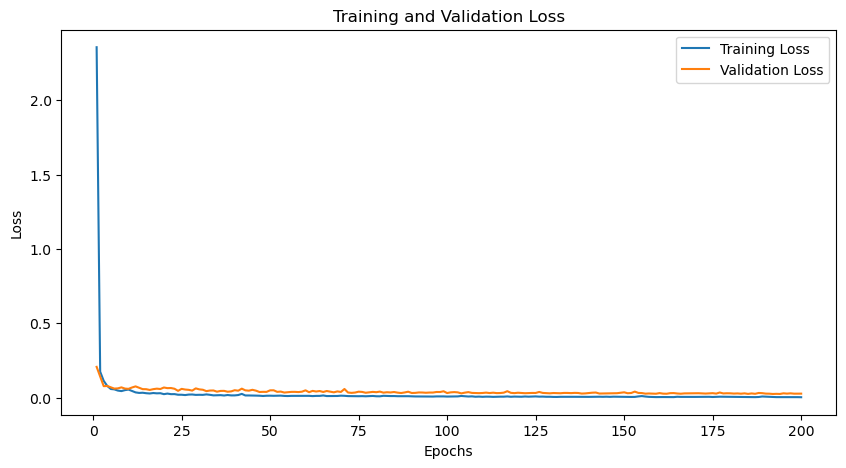

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

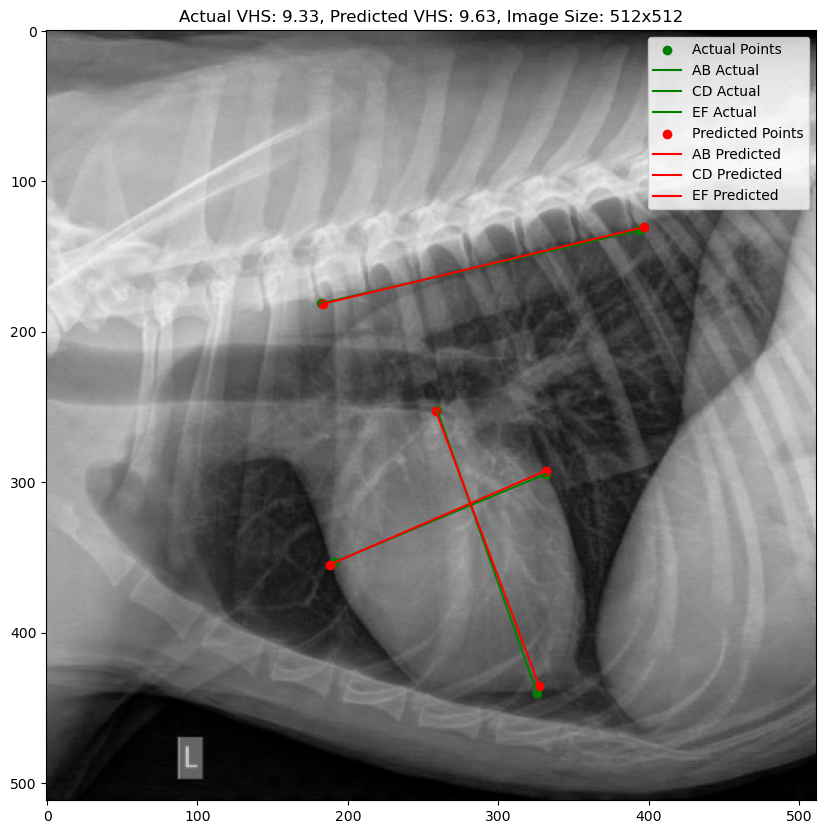

In [ ]:
import random

def visualize_predictions(model, dataset, device, idx=None):
    model.eval()
    
    if idx is None:
        idx = random.randint(0, len(dataset) - 1)
        
    img, six_points_actual, vhs_actual = dataset[idx]
    img_resized = img.to(device).unsqueeze(0)
    six_points_actual = six_points_actual.view(-1, 2).cpu().numpy()
    vhs_actual = vhs_actual.item()
    
    with torch.no_grad():
        points_resized = model(img_resized).cpu().view(-1, 2).numpy()
    
    w, h = img.shape[2], img.shape[1]
    points_resized[:, 0] *= resized_image_size
    points_resized[:, 1] *= resized_image_size
    points_resized[:, 0] = w / resized_image_size * points_resized[:, 0]
    points_resized[:, 1] = h / resized_image_size * points_resized[:, 1]
    img = img.permute(1, 2, 0).cpu().numpy()
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
    img = np.clip(img, 0, 1)
    

    vhs_predicted = calculate_vhs(torch.tensor(points_resized).view(-1))
    
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    
    plt.scatter(six_points_actual[:, 0] * w, six_points_actual[:, 1] * h, c='g', label='Actual Points')
    plt.plot([six_points_actual[0, 0] * w, six_points_actual[1, 0] * w], 
             [six_points_actual[0, 1] * h, six_points_actual[1, 1] * h], 'g-', label='AB Actual')
    plt.plot([six_points_actual[2, 0] * w, six_points_actual[3, 0] * w], 
             [six_points_actual[2, 1] * h, six_points_actual[3, 1] * h], 'g-', label='CD Actual')
    plt.plot([six_points_actual[4, 0] * w, six_points_actual[5, 0] * w], 
             [six_points_actual[4, 1] * h, six_points_actual[5, 1] * h], 'g-', label='EF Actual')

    plt.scatter(points_resized[:, 0], points_resized[:, 1], c='r', label='Predicted Points')
    plt.plot([points_resized[0, 0], points_resized[1, 0]], 
             [points_resized[0, 1], points_resized[1, 1]], 'r-', label='AB Predicted')
    plt.plot([points_resized[2, 0], points_resized[3, 0]], 
             [points_resized[2, 1], points_resized[3, 1]], 'r-', label='CD Predicted')
    plt.plot([points_resized[4, 0], points_resized[5, 0]], 
             [points_resized[4, 1], points_resized[5, 1]], 'r-', label='EF Predicted')
    
    plt.title(f'Actual VHS: {vhs_actual:.2f}, Predicted VHS: {vhs_predicted:.2f}, Image Size: {w}x{h}')
    plt.legend()
    plt.show()

visualize_predictions(model, dataset_val, device)


In [ ]:
import csv
import pandas as pd
import random

class DogHeartTestDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "Images"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "Images", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        original_size = img.size  
        if self.transforms is not None:
            img = self.transforms(img)
        return img, img_path, original_size

    def __len__(self):
        return len(self.imgs)
    
def get_test_transform(resized_image_size):
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((resized_image_size, resized_image_size)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


def test_predictions(model, dataset, device, resized_image_size=512, idx=None, save_csv=False, output_csv='test_predictions.csv'):
    model.eval()
    results = []
    vhs_score= 0

    if idx is None:
        idx = random.randint(0, len(dataset) - 1)

    for img, img_path, original_size in tqdm(dataset, desc="Processing images"):
        img_resized = img.to(device).unsqueeze(0)

        with torch.no_grad():
            outputs = model(img_resized).cpu().view(-1, 2).numpy()

        w, h = original_size

        # Scale points back to the original image size
        points_resized = outputs.reshape(-1, 2)
        points_resized[:, 0] = w * points_resized[:, 0]
        points_resized[:, 1] = h * points_resized[:, 1]

        # Calculate VHS score
        points_tensor = torch.tensor(points_resized).view(-1)
        # vhs_score = round(calculate_vhs(points_tensor), 6)
        vhs_score = round(calculate_vhs(points_tensor).item(), 4)


        filename = os.path.basename(img_path)
        results.append([filename, vhs_score])


    if save_csv:
        df = pd.DataFrame(results, columns=['filename', 'vhs_score'])
        df.to_csv(output_csv, index=False)
        print(f"Results saved to {output_csv}")



test_dataset = DogHeartTestDataset('Test_Images', get_test_transform(resized_image_size=512))
test_predictions(model, test_dataset, device, resized_image_size=512, save_csv=True, output_csv='test_predictions.csv')


Processing images: 100%|██████████| 400/400 [00:27<00:00, 14.60it/s]

Results saved to test_predictions.csv


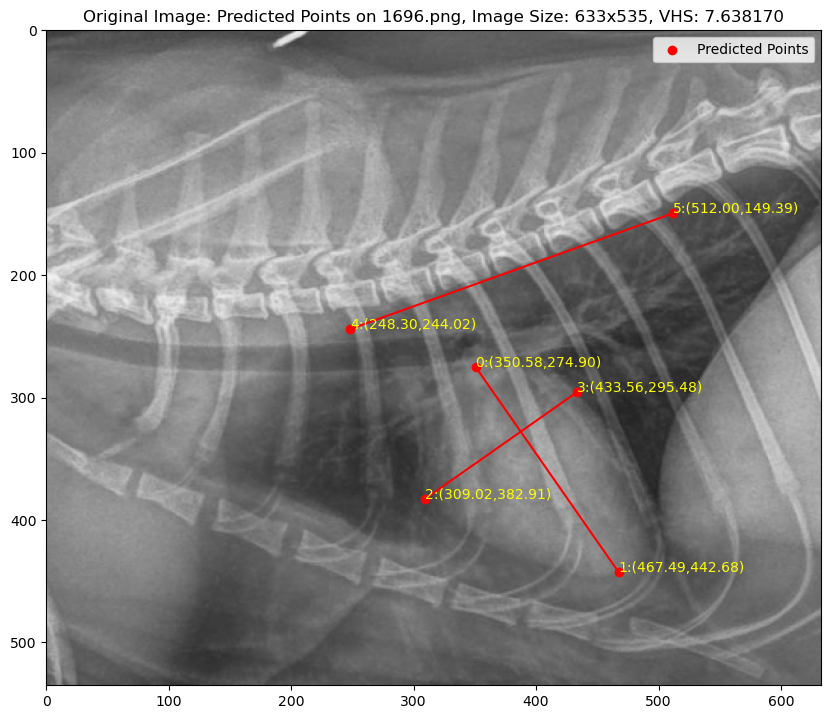

In [ ]:
def calculate_vhs(points):
    if points.shape[0] != 12:
        print("Error: Incorrect number of points, expected 12 but got", points.shape[0])
    AB = torch.dist(points[0:2], points[2:4])
    CD = torch.dist(points[4:6], points[6:8])
    EF = torch.dist(points[8:10], points[10:12])
    VHS = 6 * (AB + CD) / EF
    return VHS

def visualize_test_predictions(model, dataset, device, resized_image_size=512, idx=None):
    model.eval()
    
    if idx is None:
        idx = random.randint(0, len(dataset) - 1)
        
    img, img_path, original_size = dataset[idx]
    img_resized = img.to(device).unsqueeze(0)
    
    with torch.no_grad():
        outputs = model(img_resized).cpu().view(-1, 2).numpy()
    
    w, h = original_size
    

    points_resized = outputs.reshape(-1, 2)
    points_resized[:, 0] = w * points_resized[:, 0]
    points_resized[:, 1] = h * points_resized[:, 1]
    
    # Calculate VHS score
    points_tensor = torch.tensor(points_resized).view(-1)
    vhs_score = calculate_vhs(points_tensor).item()
    
    # Unnormalize images
    img_np = img.permute(1, 2, 0).cpu().numpy()
    img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img_np = np.clip(img_np, 0, 1)
    
    # Plot original image with predicted points
    plt.figure(figsize=(10, 10))
    plt.imshow(img_np, extent=[0, w, h, 0]) 
    plt.scatter(points_resized[:, 0], points_resized[:, 1], c='r', label='Predicted Points')
    for i, (x, y) in enumerate(points_resized):
        plt.text(x, y, f'{i}:({x:.2f},{y:.2f})', color='yellow')

    plt.plot([points_resized[0, 0], points_resized[1, 0]], [points_resized[0, 1], points_resized[1, 1]], 'r-')
    plt.plot([points_resized[2, 0], points_resized[3, 0]], [points_resized[2, 1], points_resized[3, 1]], 'r-')
    plt.plot([points_resized[4, 0], points_resized[5, 0]], [points_resized[4, 1], points_resized[5, 1]], 'r-')
    
    plt.title(f'Original Image: Predicted Points on {os.path.basename(img_path)}, Image Size: {w}x{h}, VHS: {vhs_score:.6f}')
    plt.legend()
    plt.show()


test_dataset = DogHeartTestDataset('Test_Images', get_test_transform(resized_image_size=512))
visualize_test_predictions(model, test_dataset, device, resized_image_size=512)


In [8]:
# torch.save(model.state_dict(), 'EfficientNetB7(85.25%).pth')


# class PointDetectionModel(nn.Module):
#     def __init__(self, pretrained=True):
#         super(PointDetectionModel, self).__init__()
#         self.backbone = resnet50(pretrained=pretrained)
#         self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 12)  # 12 outputs for 6 points (x, y)

#     def forward(self, x):
#         return self.backbone(x)
    
def load_model_weights(model, file_path='Resnet18model.pth'):
    model.load_state_dict(torch.load(file_path))
    print(f"Model weights loaded from {file_path}")


class EfficientNetV2XLPointDetectionModel(nn.Module):
    def __init__(self, pretrained=True):
        super(EfficientNetV2XLPointDetectionModel, self).__init__()
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b7') if pretrained else EfficientNet.from_name('efficientnet-b7')
        self.fc = nn.Linear(self.efficientnet._fc.in_features, 12)  # 6 points with (x, y) coordinates
        self.efficientnet._fc = nn.Identity() 

    def forward(self, x):
        features = self.efficientnet(x)
        outputs = self.fc(features)
        return outputs

model = EfficientNetV2XLPointDetectionModel(pretrained=True).to(device)
load_model_weights(model, file_path='EfficientNetB7(85.25%).pth')

Loaded pretrained weights for efficientnet-b7
Model weights loaded from EfficientNetB7(85.25%).pth


# 3.Evaluate your model using the test images with the [software](https://github.com/YoushanZhang/Dog-Cardiomegaly_VHS)

In [32]:
from IPython.display import Image

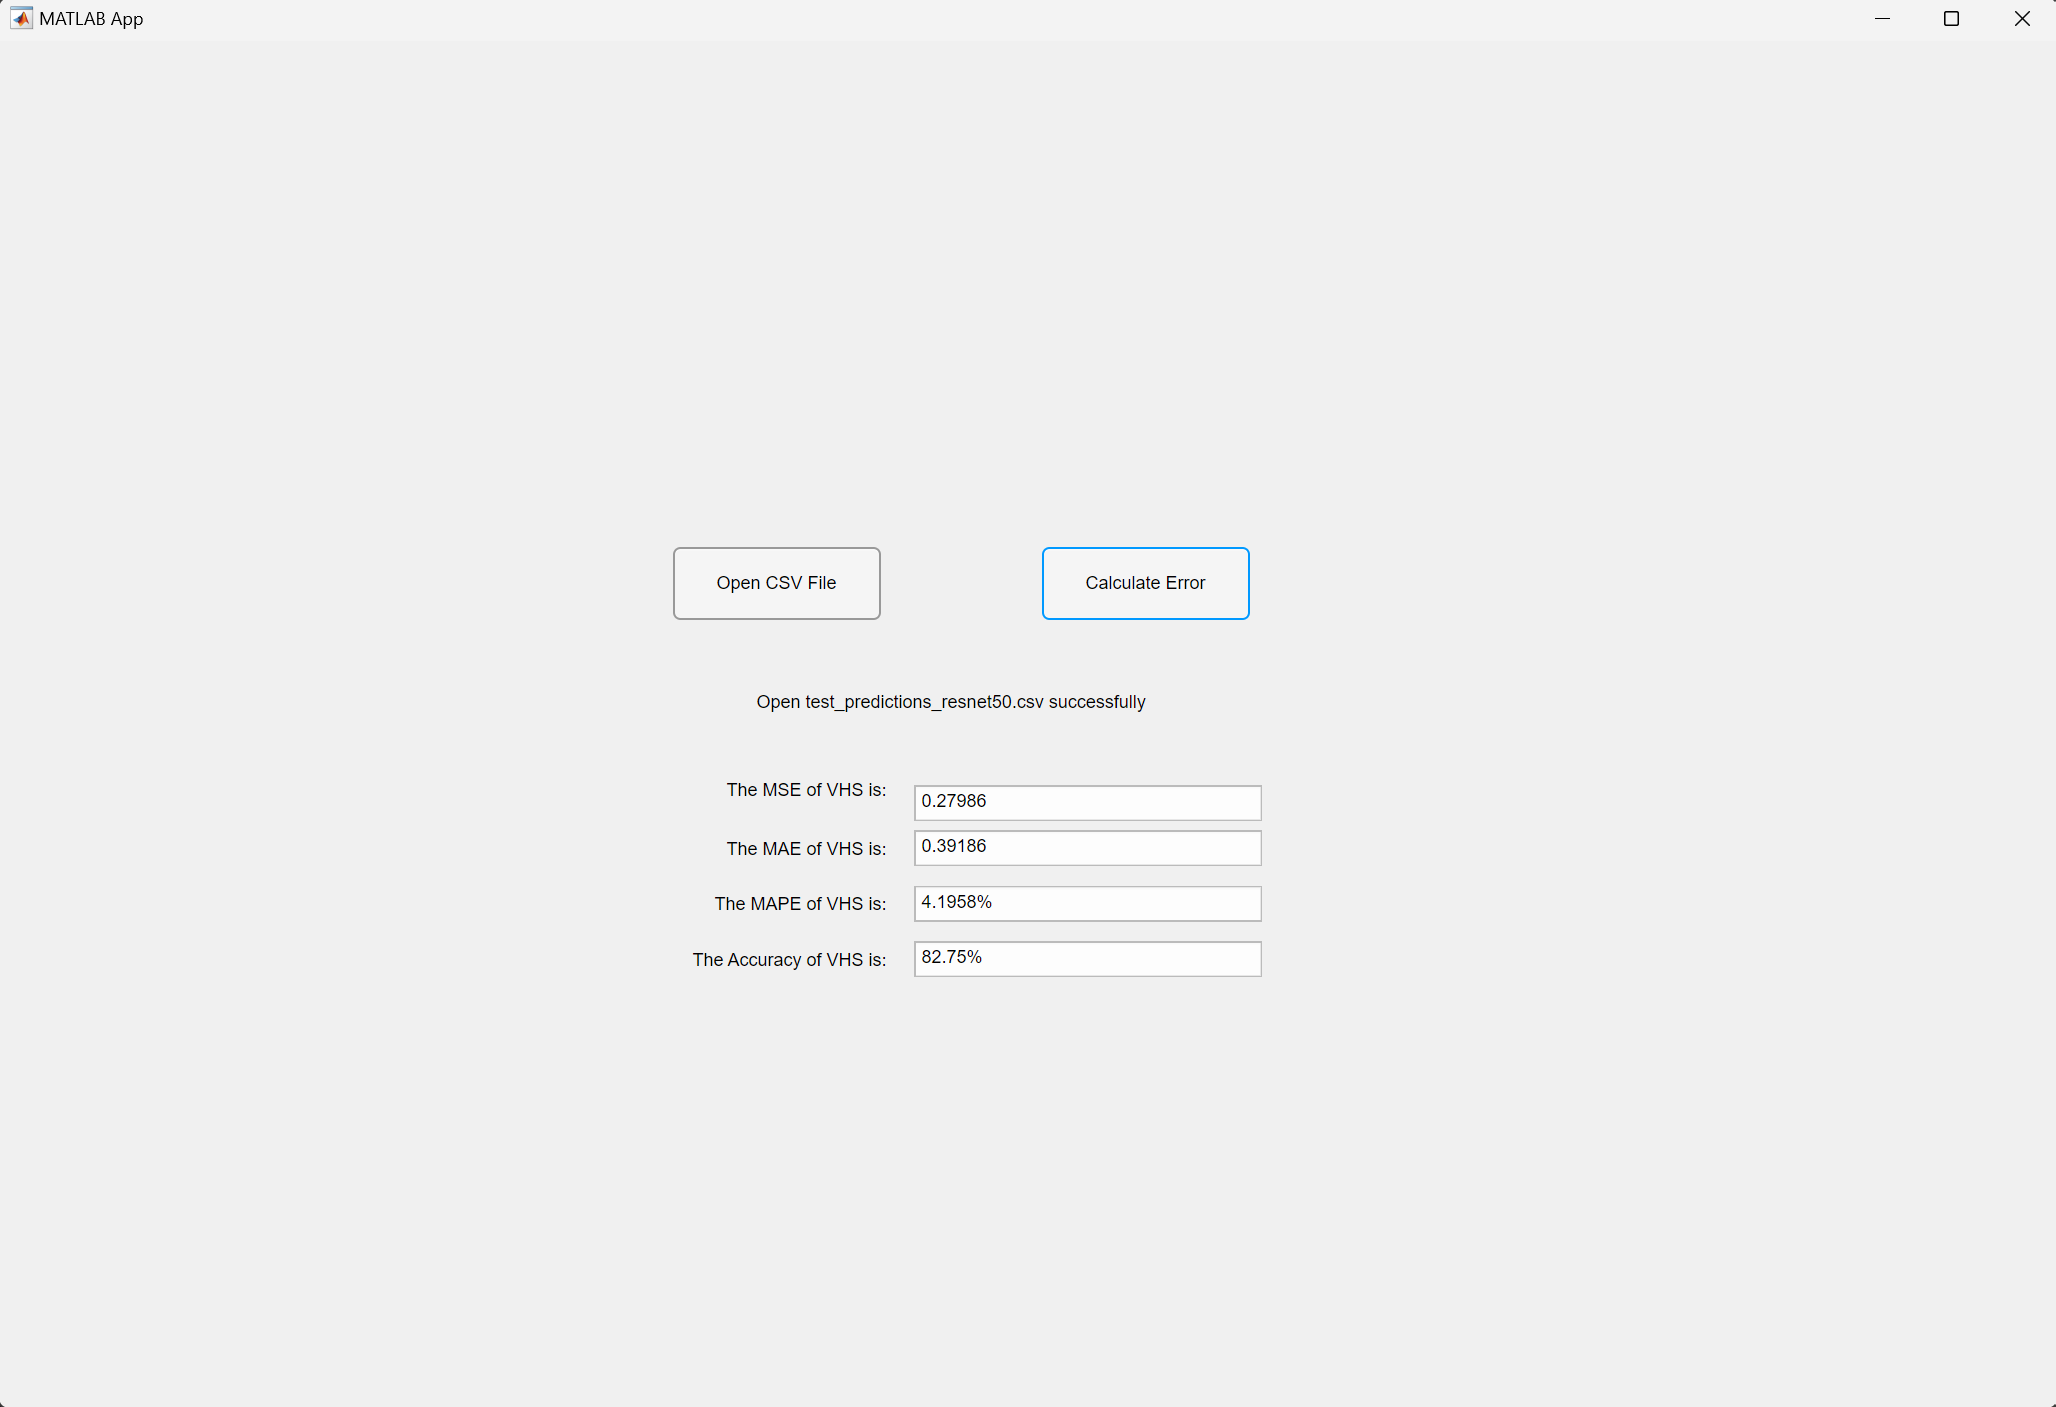

In [33]:
Image(filename='Resnet50(82.75%).png')

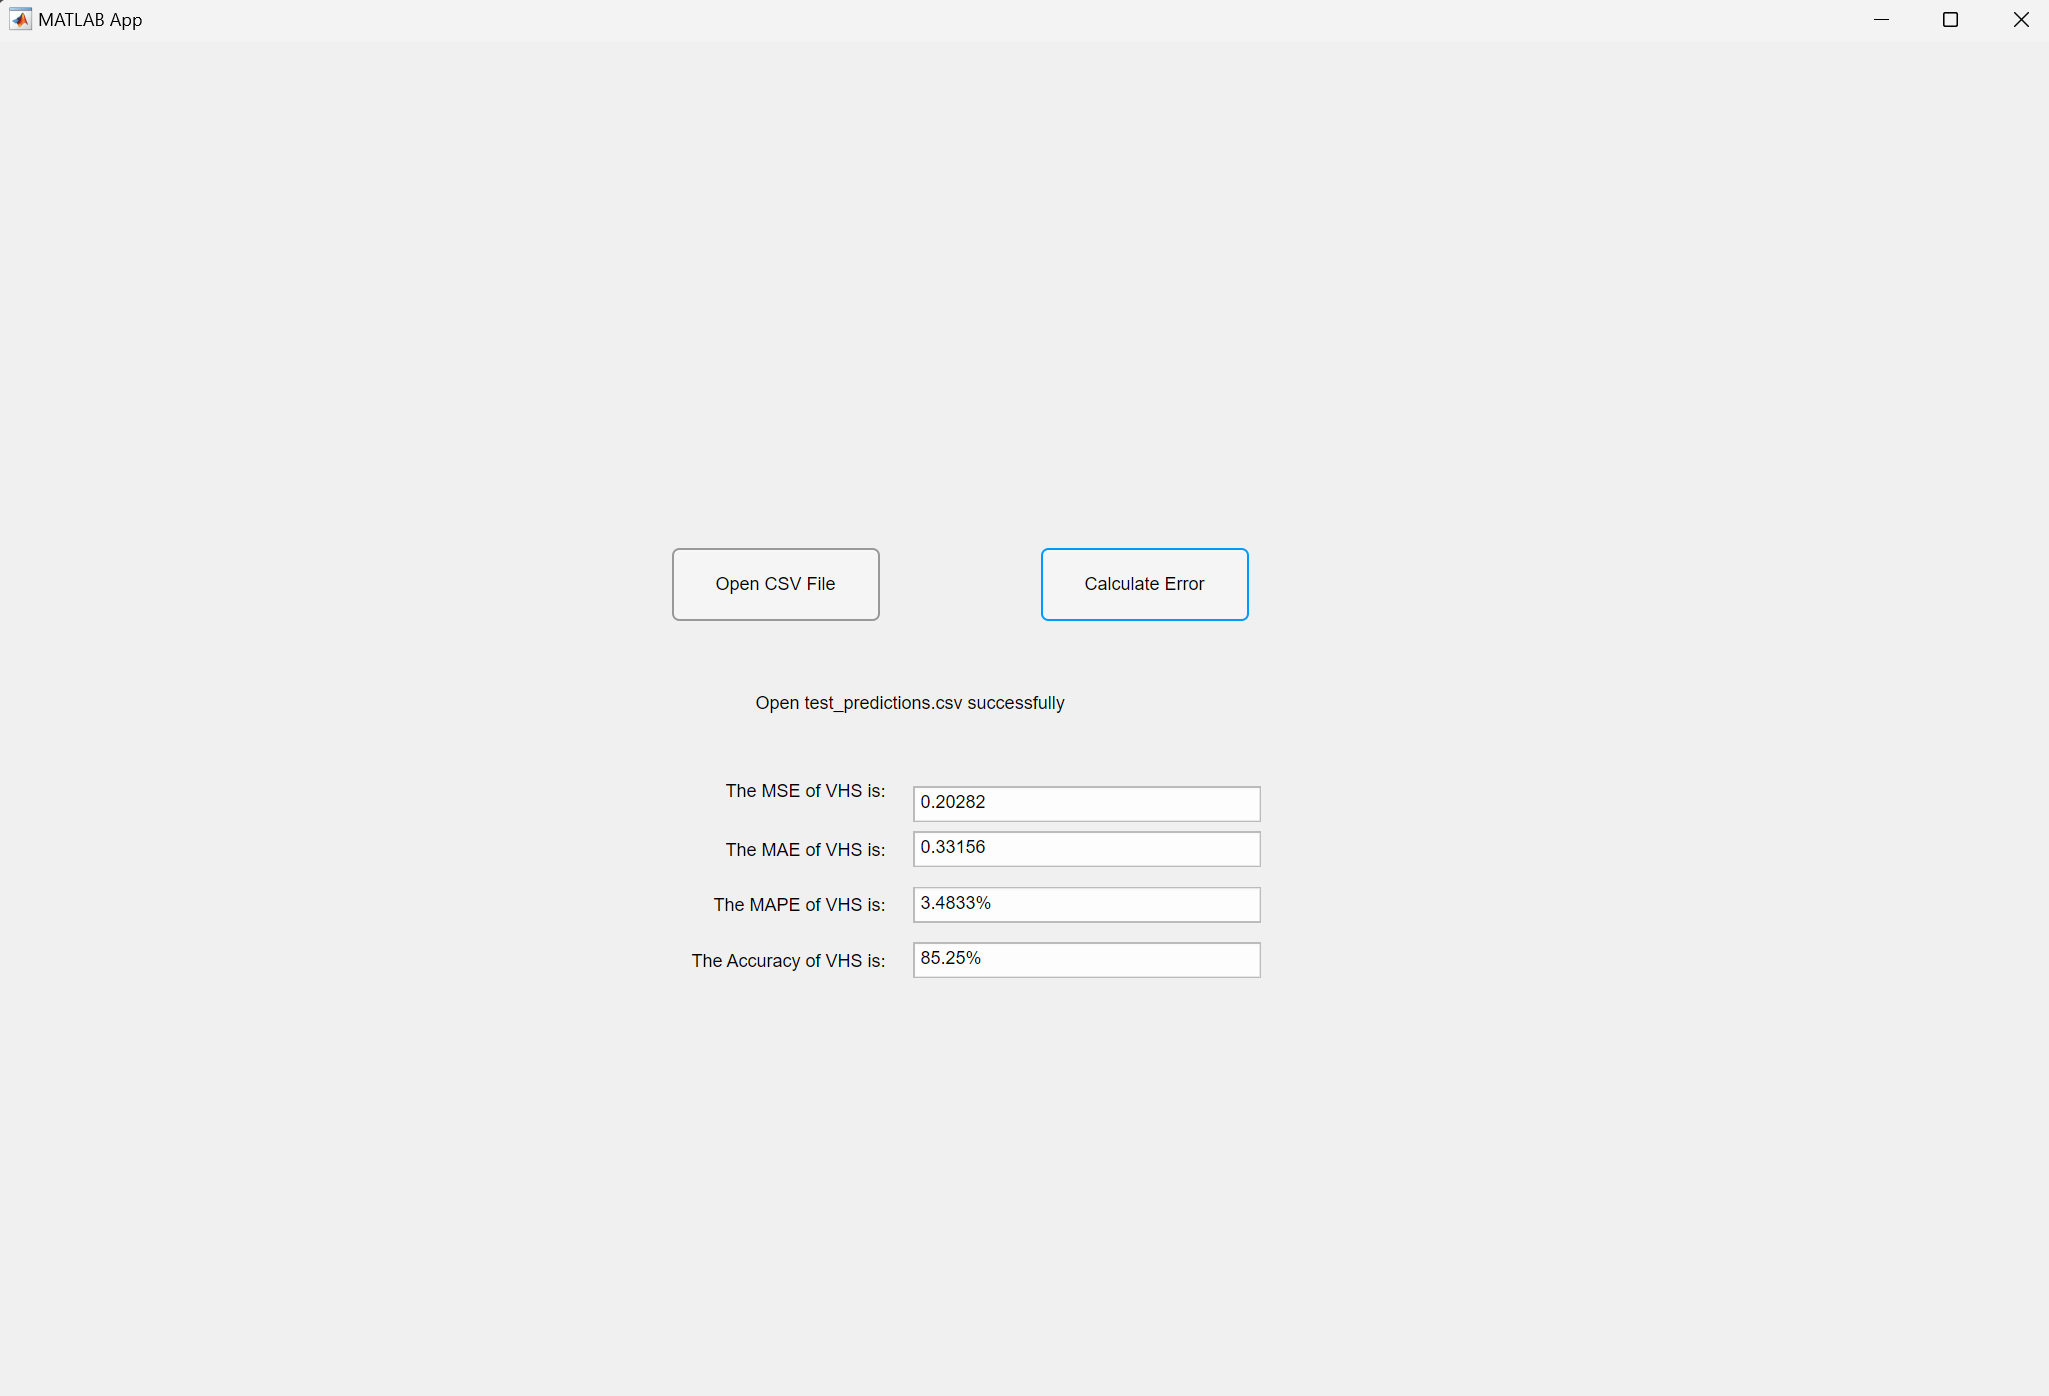

In [20]:

Image(filename='EfficientNetB7(85.25%).png')

# 4. Your results should be achieved 85%. VHS = 6(AB+CD)/EF

## (10 points, accuracy < 75% --> 0 points)

The Mean Squared Error (MSE) of 0.20282 indicates a low average squared difference between the predicted and actual VHS values, signifying high precision in our model's predictions. The Mean Absolute Error (MAE) of 0.33156 further supports the model's accuracy by showing a low average magnitude of errors. The Mean Absolute Percentage Error (MAPE) of 3.4833% reflects the model's excellent performance in relative error terms. Lastly, an impressive accuracy of 85.25% highlights the model's robustness in classifying heart sizes accurately, showcasing its potential to significantly aid veterinary diagnostics by providing reliable and automated VHS calculations.

# 5. Show the comprison between predictions and ground truth
## You need to add the title with: image name, predicted VHS and Ground Truth VHS
<p align="center">
  <img src="Com.png" width="60%"> 
</p>


# Please show the comprison results of images: 1420.png, 1479.png and 1530.png from Valid dataset

In [50]:
def get_test_transform(resized_image_size):
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((resized_image_size, resized_image_size)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def visualize(model, image_path, points_path, device):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    original_size = img.size
    img = get_test_transform(resized_image_size=512)(img).unsqueeze(0).to(device)
    mat = loadmat(points_path)
    six_points = mat['six_points'].astype(float)
    six_points = torch.as_tensor(six_points, dtype=torch.float32)
    six_points[:, 0] = six_points[:, 0] / original_size[0]
    six_points[:, 1] = six_points[:, 1] / original_size[1]
    six_points_resized = torch.reshape(six_points, (-1,)) * 512
    vhs_actual = mat['VHS'].astype(float)[0, 0]  # Convert to scalar
    with torch.no_grad():
        outputs = model(img).cpu().view(-1, 2).numpy()
    w, h = original_size
    points_resized = outputs.reshape(-1, 2)
    points_resized[:, 0] = w * points_resized[:, 0]
    points_resized[:, 1] = h * points_resized[:, 1]
    points_tensor = torch.tensor(points_resized).view(-1)
    vhs_score = calculate_vhs(points_tensor).item()
    img_np = img.squeeze(0).permute(1, 2, 0).cpu().numpy()
    img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img_np = np.clip(img_np, 0, 1)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_np, extent=[0, w, h, 0])
    plt.scatter(points_resized[:, 0], points_resized[:, 1], c='r', label='Predicted Points')
    for i, (x, y) in enumerate(points_resized):
        plt.text(x, y, f'{i}:({x:.2f},{y:.2f})', color='yellow')
    plt.plot([points_resized[0, 0], points_resized[1, 0]], [points_resized[0, 1], points_resized[1, 1]], 'r-')
    plt.plot([points_resized[2, 0], points_resized[3, 0]], [points_resized[2, 1], points_resized[3, 1]], 'r-')
    plt.plot([points_resized[4, 0], points_resized[5, 0]], [points_resized[4, 1], points_resized[5, 1]], 'r-')
    

    if six_points.shape[0] == 6 and six_points.shape[1] == 2:
        # Scale actual points back to original image size
        six_points[:, 0] *= w
        six_points[:, 1] *= h
        plt.scatter(six_points[:, 0], six_points[:, 1], c='g', label='Actual Points')
        plt.plot([six_points[0, 0], six_points[1, 0]], [six_points[0, 1], six_points[1, 1]], 'g-')
        plt.plot([six_points[2, 0], six_points[3, 0]], [six_points[2, 1], six_points[3, 1]], 'g-')
        plt.plot([six_points[4, 0], six_points[5, 0]], [six_points[4, 1], six_points[5, 1]], 'g-')
    else:
        print("six_points does not have the expected shape")
    
    plt.title(f'Original Image: Predicted Points on {os.path.basename(image_path)}, Image Size: {w}x{h}, Predicted VHS: {vhs_score:.6f}, Actual VHS: {vhs_actual:.6f}')
    plt.legend()
    plt.show()


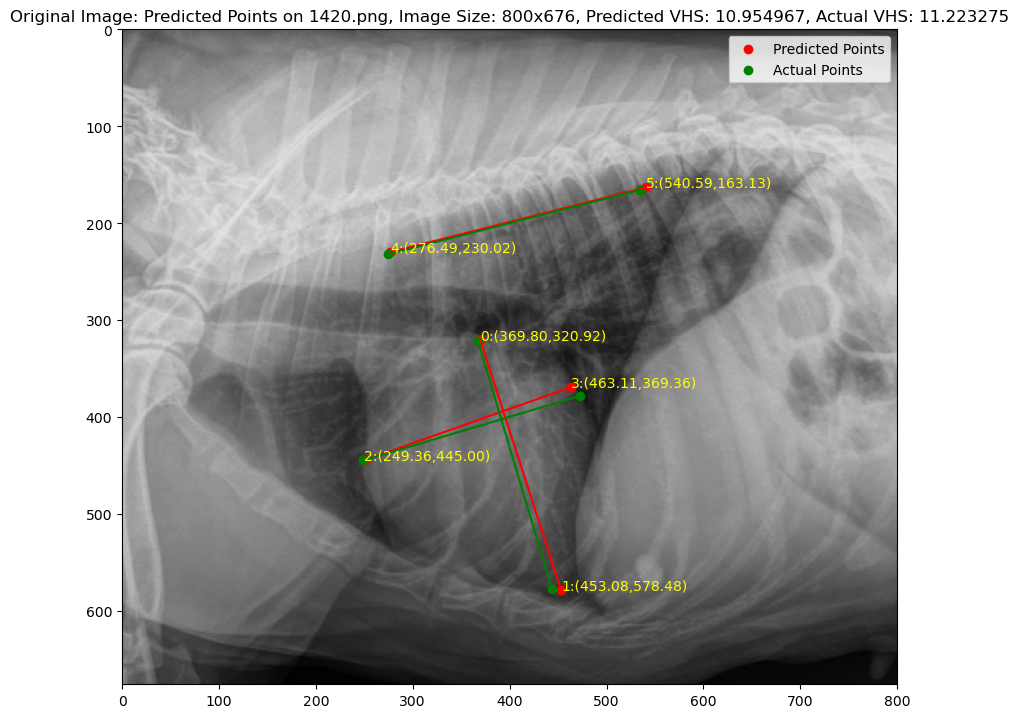

In [51]:
image = 'Valid\\Images\\1420.png'
points = 'Valid\\Labels\\1420.mat'
visualize(model, image, points, device)

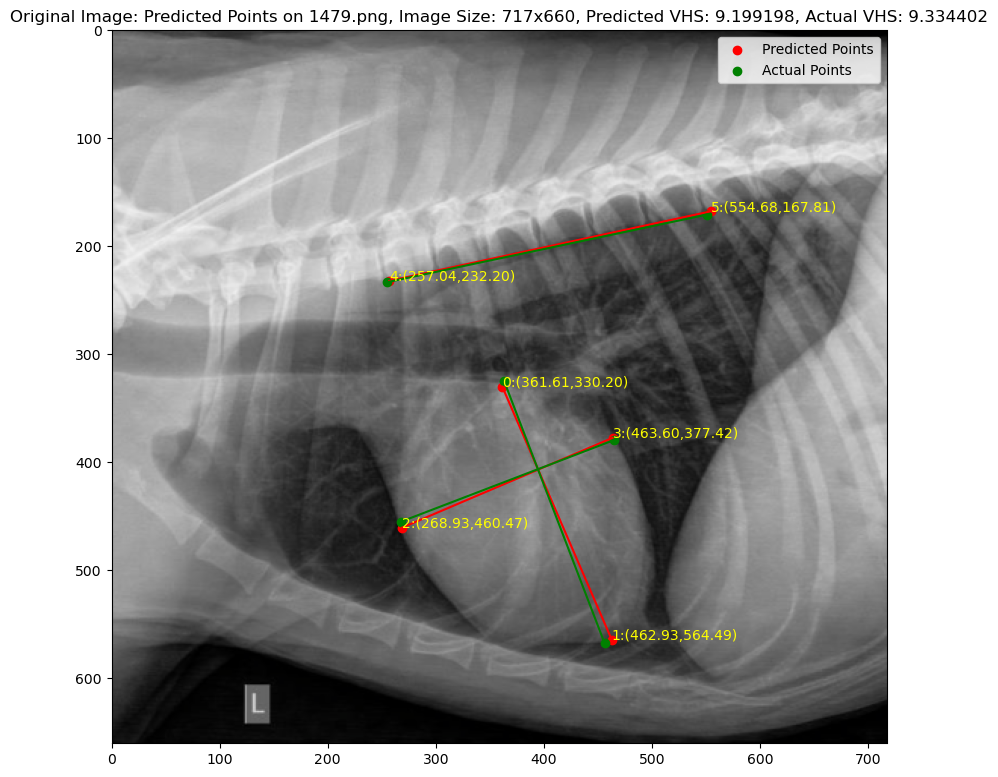

In [52]:
image = 'Valid\\Images\\1479.png'
points = 'Valid\\Labels\\1479.mat'
visualize(model, image, points, device)

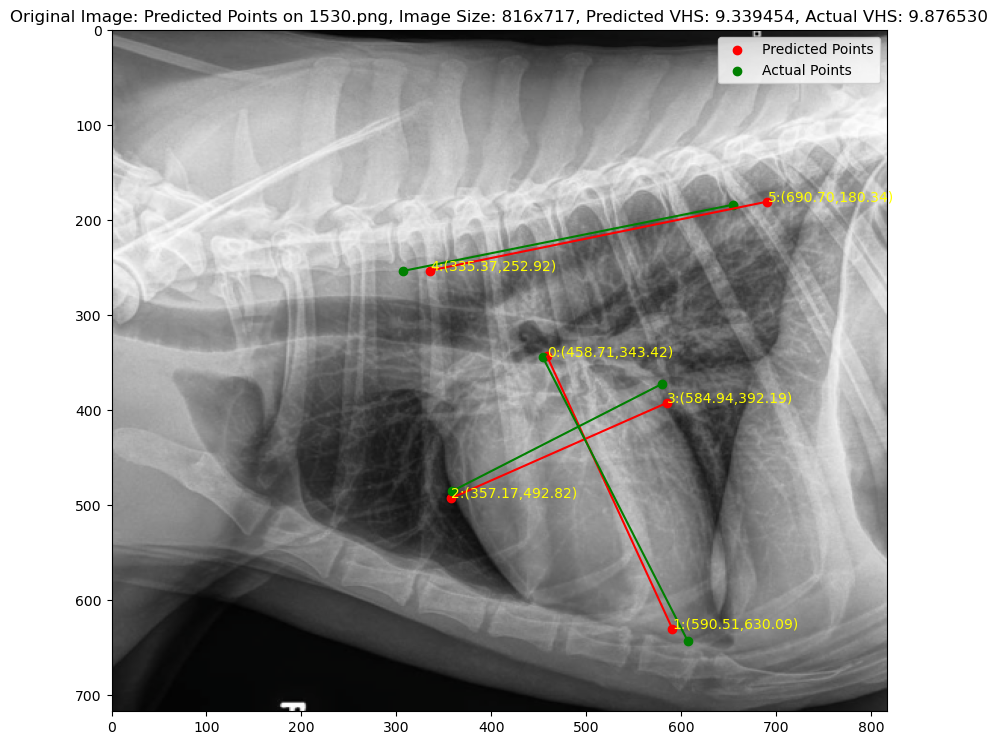

In [53]:
image = 'Valid\\Images\\1530.png'
points = 'Valid\\Labels\\1530.mat'
visualize(model, image, points, device)

# 6. Write a three-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.


### Research Gate Link: https://www.researchgate.net/publication/382490224_Vertebral_Heart_Score-Based_Canine_Cardiomegaly_Detection_Using_Deep_Learning
### GitHub Weights Link: https://github.com/Nurath/VHS-Based-Canine-Cardiomegaly-Detection-Weights

# 7. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file, prediction CSV file and add paper link)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

(6). Discussion - 10 points

# 8. Bonus points (10 points if your accuracy is higer than 87.3%)